In [ ]:
# 25 de noviembre del 2025

"""
Proyecto: Procesamiento de imágenes y representación de características
Rodrigo Gonzaga Sierra
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix, precision_score, recall_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

plt.style.use('default')
#sns.set_palette("husl")


In [ ]:
class ImageProcessor:
    """Clase para procesamiento y análisis de imágenes con métodos tradicionales"""

    def __init__(self):
        self.datasets = {}
        self.results = {}

    def load_mnist(self):
        """Carga MNIST usando torchvision"""
        print("Cargando MNIST...")
        try:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

            trainset = torchvision.datasets.MNIST(
                root='./data', train=True, download=True, transform=transform)

            X_list = []
            y_list = []
            for img, label in trainset:
                X_list.append(img.numpy().flatten())
                y_list.append(label)

            X = np.array(X_list)
            y = np.array(y_list)

            self.datasets['mnist'] = {
                'data': X,
                'target': y,
                'target_names': np.array([str(i) for i in range(10)]),
                'shape': (28, 28),
                'name': 'MNIST Digits'
            }
            print(f"MNIST cargado: {X.shape[0]} imágenes")

        except Exception as e:
            print(f"Error cargando MNIST: {e}")
            self._create_sample_data('mnist', (28, 28))

    def load_fashion_mnist(self):
        """Carga Fashion-MNIST usando torchvision"""
        print("Cargando Fashion-MNIST...")
        try:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

            trainset = torchvision.datasets.FashionMNIST(
                root='./data', train=True, download=True, transform=transform)

            X_list = []
            y_list = []
            for img, label in trainset:
                X_list.append(img.numpy().flatten())
                y_list.append(label)

            X = np.array(X_list)
            y = np.array(y_list)

            self.datasets['fashion'] = {
                'data': X,
                'target': y,
                'target_names': np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                                          'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']),
                'shape': (28, 28),
                'name': 'Fashion-MNIST'
            }
            print(f"Fashion-MNIST cargado: {X.shape[0]} imágenes")

        except Exception as e:
            print(f"Error cargando Fashion-MNIST: {e}")
            self._create_sample_data('fashion', (28, 28))

    def load_cifar10(self):
        """Carga CIFAR-10 usando torchvision y convierte a escala de grises"""
        print("Cargando CIFAR-10...")
        try:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

            trainset = torchvision.datasets.CIFAR10(
                root='./data', train=True, download=True, transform=transform)

            X_list = []
            y_list = []
            for img, label in trainset:
                img_gray = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
                X_list.append(img_gray.numpy().flatten())
                y_list.append(label)

            X = np.array(X_list)
            y = np.array(y_list)

            self.datasets['cifar10'] = {
                'data': X,
                'target': y,
                'target_names': np.array([
                    "airplane", "automobile", "bird", "cat", "deer",
                    "dog", "frog", "horse", "ship", "truck"]),
                'shape': (32, 32),
                'name': 'CIFAR-10 (grayscale)'
            }
            print(f"CIFAR-10 cargado: {X.shape[0]} imágenes")

        except Exception as e:
            print(f"Error cargando CIFAR-10: {e}")
            self._create_sample_data('cifar10', (32, 32))

    def _create_sample_data(self, dataset_name, shape):
        """Crea datos de ejemplo si falla la descarga"""
        n_samples = 1000
        img_size = np.prod(shape)
        np.random.seed(42)
        X = np.random.randn(n_samples, img_size) * 0.1 + 0.5
        X = np.clip(X, 0, 1)
        y = np.random.randint(0, 10, n_samples)

        if dataset_name == 'mnist':
            target_names = [str(i) for i in range(10)]
        elif dataset_name == 'fashion':
            target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        else:
            target_names = ["airplane", "automobile", "bird", "cat", "deer",
                           "dog", "frog", "horse", "ship", "truck"]

        self.datasets[dataset_name] = {
            'data': X,
            'target': y,
            'target_names': np.array(target_names),
            'shape': shape,
            'name': f'{dataset_name.upper()} (Sample Data)'
        }
        print(f"Usando datos de ejemplo para {dataset_name}")

    def preprocess_data(self, dataset_name, n_samples=5000):
        dataset = self.datasets[dataset_name]
        X = dataset['data']
        y = dataset['target']

        if X.ndim > 2:
            X = X.reshape(X.shape[0], -1)

        if n_samples < len(X):
            np.random.seed(42)
            idx = np.random.choice(len(X), n_samples, replace=False)
            X = X[idx]
            y = y[idx]

        scaler = MinMaxScaler()
        X_norm = scaler.fit_transform(X)
        return X_norm, y

    def apply_pca(self, X, n_components=50):
        pca = PCA(n_components=n_components, random_state=42)
        X_pca = pca.fit_transform(X)
        return {
            'transformed': X_pca,
            'model': pca,
            'components': pca.components_
        }

    def apply_nmf(self, X, n_components=20):
        X_pos = X - np.min(X) + 1e-8
        nmf = NMF(n_components=n_components, init='nndsvda',
                  random_state=42, max_iter=500)
        return {
            'transformed': nmf.fit_transform(X_pos),
            'model': nmf,
            'components': nmf.components_
        }

    def apply_tsne(self, X, n_components=2):
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        return tsne.fit_transform(X)

    def apply_clustering(self, X, n_clusters=10):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)
        return labels, kmeans

    def visualize_components(self, dataset_name, method='pca', n_components=15):
        components = self.results[dataset_name][method]['components']
        shape = self.datasets[dataset_name]['shape']

        n_cols = 5
        n_rows = (n_components + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
        axes = axes.flatten()

        for i in range(n_components):
            if i < len(components):
                axes[i].imshow(components[i].reshape(shape), cmap='viridis')
                axes[i].set_title(f"{method.upper()} {i+1}")
                axes[i].axis("off")

        for i in range(n_components, len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

    def visualize_reduction(self, dataset_name, method='pca'):
        X_red = self.results[dataset_name][method]['transformed']
        y = self.results[dataset_name]['y']

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(X_red[:, 0], X_red[:, 1], c=y, cmap='tab10', s=8, alpha=0.6)
        plt.title(f"{method.upper()} – {self.datasets[dataset_name]['name']}")
        plt.xlabel("Comp 1")
        plt.ylabel("Comp 2")
        plt.colorbar(scatter)
        plt.show()

    def visualize_sample_images(self, dataset_name, n_samples=10):
        """Muestra imágenes de muestra del dataset"""
        dataset = self.datasets[dataset_name]
        X = dataset['data']
        y = dataset['target']
        shape = dataset['shape']
        target_names = dataset['target_names']
        np.random.seed(42)
        indices = np.random.choice(len(X), n_samples, replace=False)

        n_cols = 5
        n_rows = (n_samples + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
        axes = axes.flatten()

        for i, idx in enumerate(indices):
            if i < len(axes):
                img = X[idx].reshape(shape)
                axes[i].imshow(img, cmap='gray')
                axes[i].set_title(f"Clase: {target_names[y[idx]]}")
                axes[i].axis("off")

        for i in range(len(indices), len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.suptitle(f"Imágenes de muestra - {dataset['name']}", y=1.02)
        plt.show()

    def analyze_dataset(self, dataset_name, n_samples=3000):
        print(f"\n========= Analizando {dataset_name.upper()} =========")

        self.visualize_sample_images(dataset_name, 10)

        X, y = self.preprocess_data(dataset_name, n_samples)
        self.results[dataset_name] = {'y': y}

        print("Aplicando PCA...")
        pca_res = self.apply_pca(X)
        self.results[dataset_name]['pca'] = pca_res

        print("Aplicando NMF...")
        nmf_res = self.apply_nmf(X)
        self.results[dataset_name]['nmf'] = nmf_res

        print("Aplicando t-SNE...")
        tsne_res = self.apply_tsne(pca_res['transformed'][:, :50])
        self.results[dataset_name]['tsne'] = tsne_res

        print("Aplicando clustering...")
        pca_labels, _ = self.apply_clustering(pca_res['transformed'][:, :20])
        nmf_labels, _ = self.apply_clustering(nmf_res['transformed'])
        self.results[dataset_name]['pca_clusters'] = pca_labels
        self.results[dataset_name]['nmf_clusters'] = nmf_labels

        print("Generando visualizaciones...")
        self.visualize_components(dataset_name, 'pca')
        self.visualize_components(dataset_name, 'nmf')
        self.visualize_reduction(dataset_name, 'pca')

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(tsne_res[:, 0], tsne_res[:, 1], c=y, cmap='tab10', s=8, alpha=0.6)
        plt.title(f"t-SNE – {self.datasets[dataset_name]['name']}")
        plt.colorbar(scatter)
        plt.show()

        self.evaluate_clustering(dataset_name)
        return self.results[dataset_name]

    def evaluate_clustering(self, dataset_name):
        y_true = self.results[dataset_name]['y']
        pca_labels = self.results[dataset_name]['pca_clusters']
        nmf_labels = self.results[dataset_name]['nmf_clusters']

        X_pca = self.results[dataset_name]['pca']['transformed'][:, :20]
        X_nmf = self.results[dataset_name]['nmf']['transformed']

        print("\nEvaluación de clustering:")
        print(f"PCA – Adjusted Rand Score: {adjusted_rand_score(y_true, pca_labels):.3f}")
        print(f"NMF – Adjusted Rand Score: {adjusted_rand_score(y_true, nmf_labels):.3f}")
        print(f"PCA – Silhouette Score: {silhouette_score(X_pca, pca_labels):.3f}")
        print(f"NMF – Silhouette Score: {silhouette_score(X_nmf, nmf_labels):.3f}")

In [ ]:


class NeuralNetworks:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.results = {}
        print(f"Redes neuronales usando: {self.device}")

    def train_mnist_network(self):

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                              download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                                  shuffle=True, num_workers=2)

        testset = torchvision.datasets.MNIST(root='./data', train=False,
                                             download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                                 shuffle=False, num_workers=2)

        class MNISTNet(nn.Module):
            def __init__(self):
                super().__init__()
                self.fc1 = nn.Linear(28 * 28, 64)
                self.fc2 = nn.Linear(64, 10)

            def forward(self, x):
                x = torch.flatten(x, 1)
                x = torch.relu(self.fc1(x))
                x = self.fc2(x)
                return x

        net = MNISTNet().to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

        train_losses = []
        print("Iniciando entrenamiento...")
        for epoch in range(5):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(trainloader)
            train_losses.append(avg_loss)
            print(f'Época {epoch+1}/5, Pérdida: {avg_loss:.3f}')

        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')

        print(f'\nResultados MNIST:')
        print(f'Precisión: {accuracy:.2f}%')
        print(f'Precisión (métrica): {precision:.4f}')
        print(f'Exhaustividad: {recall:.4f}')

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
#        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        sns.heatmap(cm, annot=True)
        plt.title('Matriz de Confusión - MNIST')
        plt.ylabel('Etiqueta Real')
        plt.xlabel('Etiqueta Predicha')
        plt.show()

        self.results['mnist'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': cm
        }

    def train_fashion_network(self):

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                     download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                                  shuffle=True, num_workers=2)

        testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                    download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                                 shuffle=False, num_workers=2)

        classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

        class FashionNet(nn.Module):
            def __init__(self):
                super().__init__()
                self.fc1 = nn.Linear(28 * 28, 256)
                self.fc2 = nn.Linear(256, 64)
                self.fc3 = nn.Linear(64, 10)

            def forward(self, x):
                x = torch.flatten(x, 1)
                x = torch.relu(self.fc1(x))
                x = torch.sigmoid(self.fc2(x))
                x = self.fc3(x)
                return x

        net = FashionNet().to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

        train_losses = []
        print("Iniciando entrenamiento...")
        for epoch in range(5):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(trainloader)
            train_losses.append(avg_loss)
            print(f'Época {epoch+1}/5, Pérdida: {avg_loss:.3f}')

        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')

        print(f'\nResultados Fashion-MNIST:')
        print(f'Precisión: {accuracy:.2f}%')
        print(f'Precisión (métrica): {precision:.4f}')
        print(f'Exhaustividad: {recall:.4f}')

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(12, 8))
        df_cm = pd.DataFrame(cm, index=classes, columns=classes)
#        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
        sns.heatmap(df_cm, annot=True)
        plt.title('Matriz de Confusión - Fashion-MNIST')
        plt.ylabel('Etiqueta Real')
        plt.xlabel('Etiqueta Predicha')
        plt.tight_layout()
        plt.show()

        print("\nMétricas por clase:")
        for i, class_name in enumerate(classes):
            class_precision = precision_score(all_labels, all_preds, average=None)[i]
            class_recall = recall_score(all_labels, all_preds, average=None)[i]
            print(f'{class_name:12s}: Precisión={class_precision:.3f}, Recall={class_recall:.3f}')

        self.results['fashion'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': cm
        }

    def train_cifar_network(self, use_lenet=False):

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                                  shuffle=True, num_workers=2)

        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                                 shuffle=False, num_workers=2)

        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')

        if use_lenet:
            class LeNet(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.conv1 = nn.Conv2d(3, 6, 5)
                    self.pool = nn.MaxPool2d(2, 2)
                    self.conv2 = nn.Conv2d(6, 16, 5)
                    self.fc1 = nn.Linear(16 * 5 * 5, 120)
                    self.fc2 = nn.Linear(120, 84)
                    self.fc3 = nn.Linear(84, 10)

                def forward(self, x):
                    x = self.pool(torch.relu(self.conv1(x)))
                    x = self.pool(torch.relu(self.conv2(x)))
                    x = torch.flatten(x, 1)
                    x = torch.relu(self.fc1(x))
                    x = torch.relu(self.fc2(x))
                    x = self.fc3(x)
                    return x

            net = LeNet().to(self.device)
            model_name = "LeNet"
        else:
            class CIFARNet(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.fc1 = nn.Linear(3 * 32 * 32, 512)
                    self.fc2 = nn.Linear(512, 10)

                def forward(self, x):
                    x = torch.flatten(x, 1)
                    x = torch.relu(self.fc1(x))
                    x = self.fc2(x)
                    return x

            net = CIFARNet().to(self.device)
            model_name = "Fully Connected"

        print(f"Arquitectura: {model_name}")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

        print("Iniciando entrenamiento...")
        for epoch in range(5):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(trainloader)
            print(f'Época {epoch+1}/5, Pérdida: {avg_loss:.3f}')

        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')

        print(f'\nResultados CIFAR-10 ({model_name}):')
        print(f'Precisión: {accuracy:.2f}%')
        print(f'Precisión (métrica): {precision:.4f}')
        print(f'Exhaustividad: {recall:.4f}')

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(12, 8))
        df_cm = pd.DataFrame(cm, index=classes, columns=classes)
        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusión - CIFAR-10 ({model_name})')
        plt.ylabel('Etiqueta Real')
        plt.xlabel('Etiqueta Predicha')
        plt.tight_layout()
        plt.show()

        key = f'cifar10_{"lenet" if use_lenet else "fc"}'
        self.results[key] = {
            'model': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': cm
        }



PROYECTO FINAL - ANÁLISIS DE IMÁGENES Y REDES NEURONALES

1.PCA, NMF, Clustering
Cargando MNIST...
MNIST cargado: 60000 imágenes
Cargando Fashion-MNIST...
Fashion-MNIST cargado: 60000 imágenes
Cargando CIFAR-10...
CIFAR-10 cargado: 50000 imágenes

========= Analizando MNIST =========


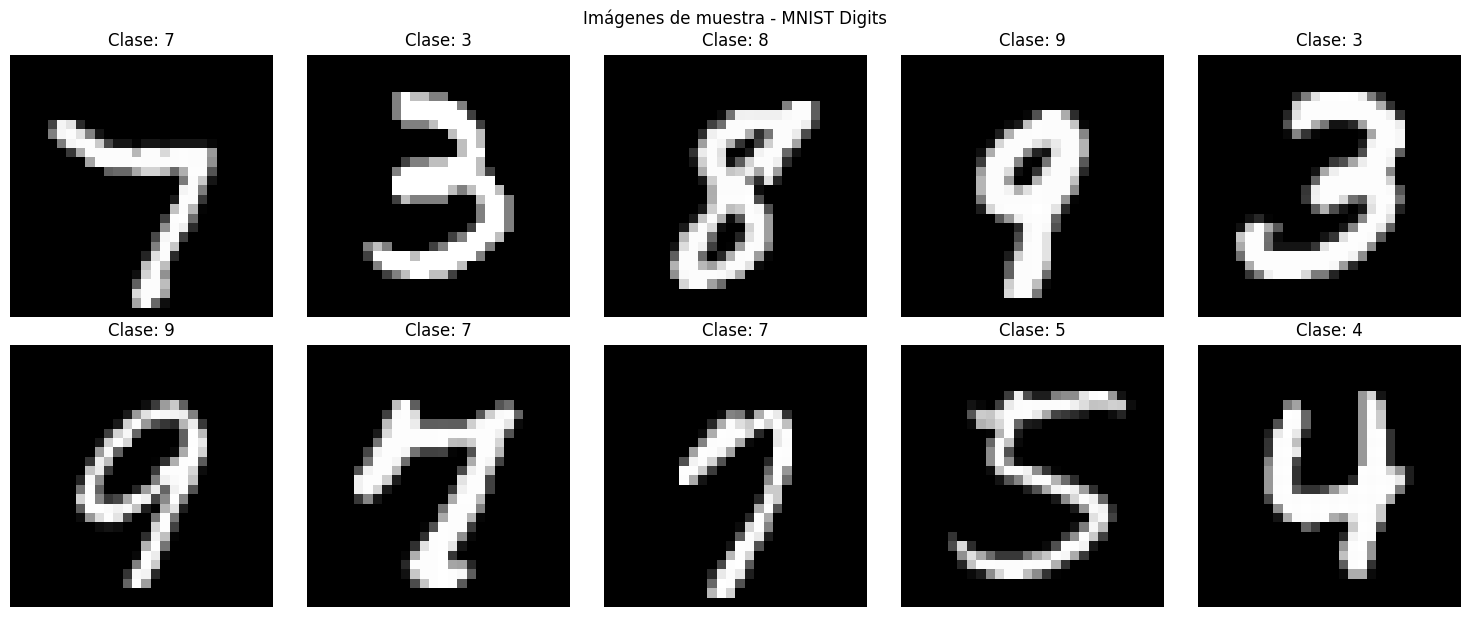

Aplicando PCA...
Aplicando NMF...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Aplicando t-SNE...
Aplicando clustering...
Generando visualizaciones...


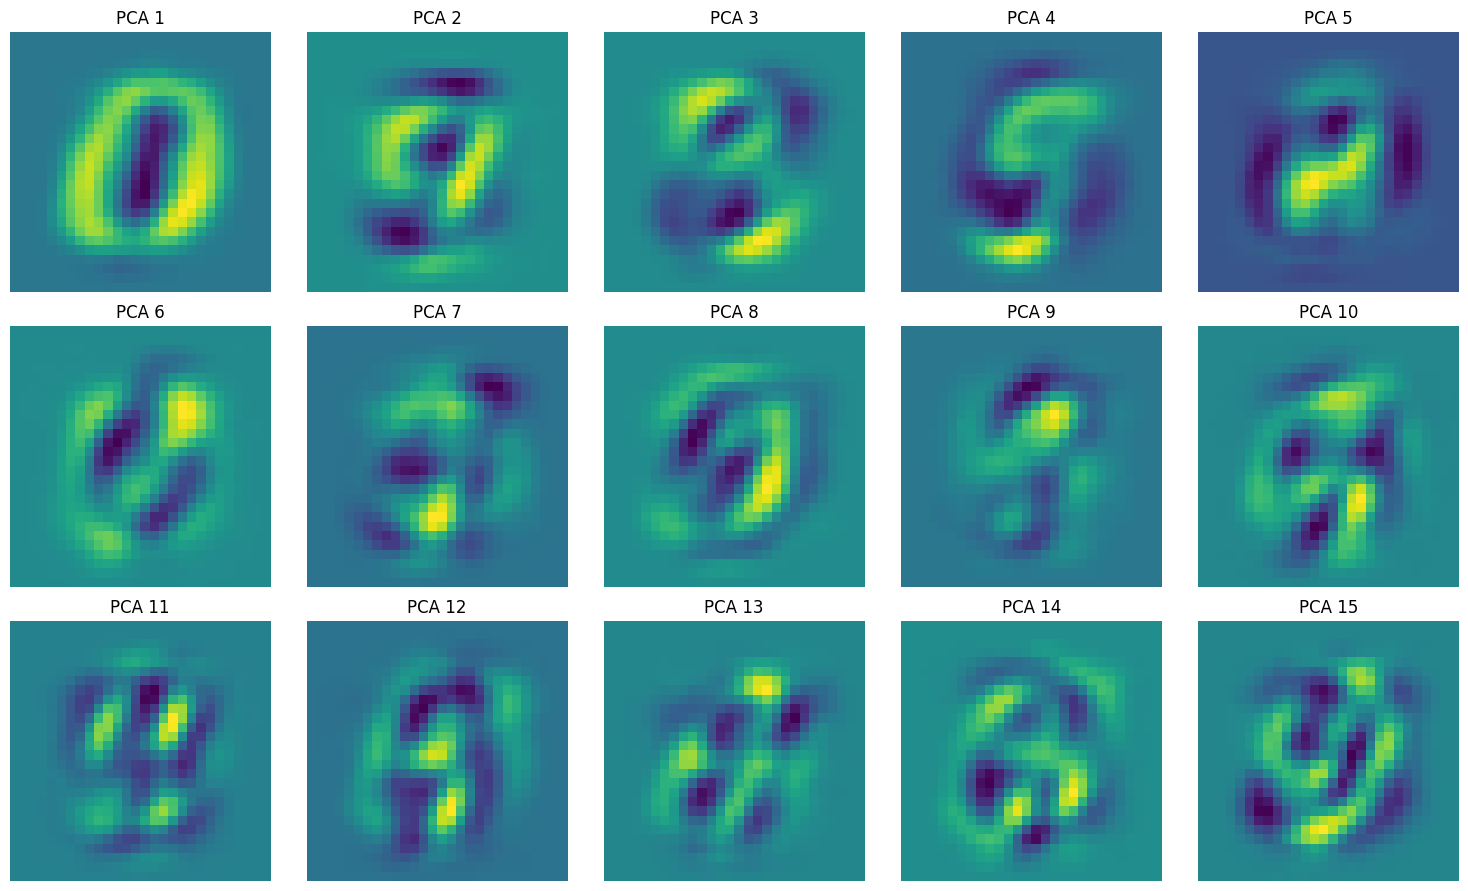

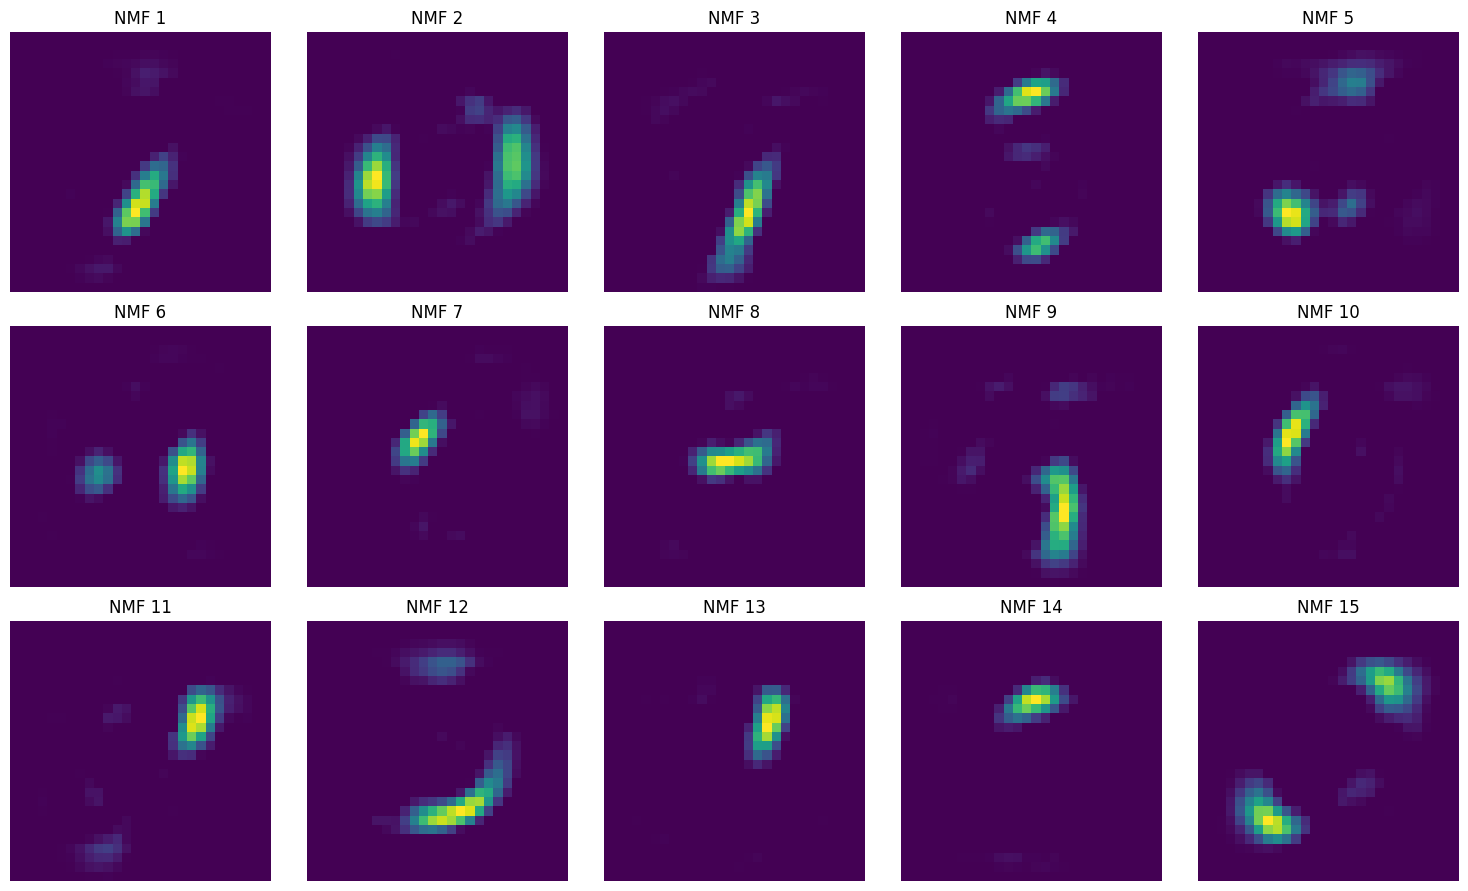

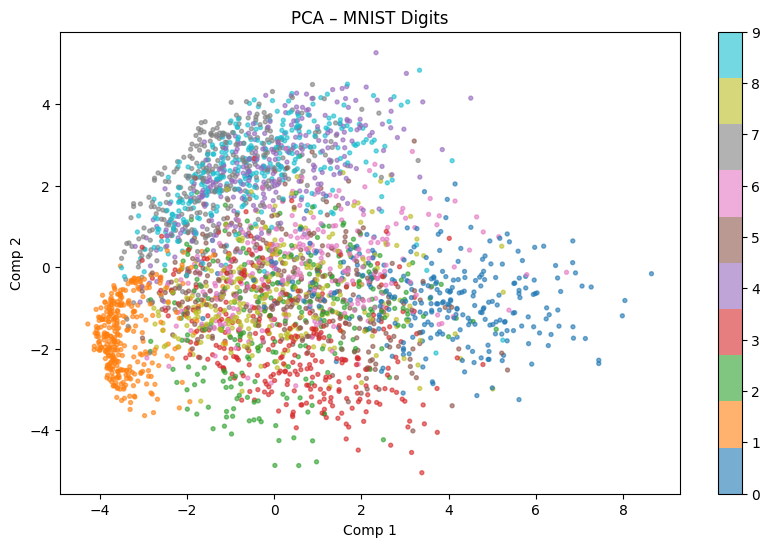

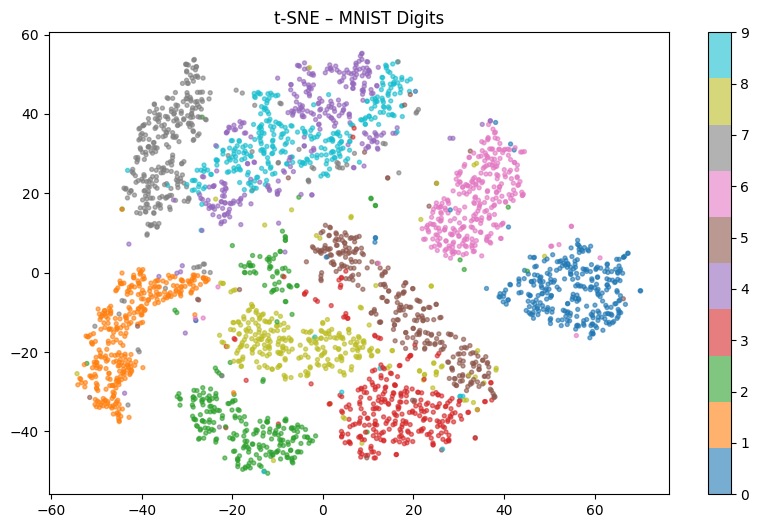


Evaluación de clustering:
PCA – Adjusted Rand Score: 0.358
NMF – Adjusted Rand Score: 0.165
PCA – Silhouette Score: 0.116
NMF – Silhouette Score: 0.132

========= Analizando FASHION =========


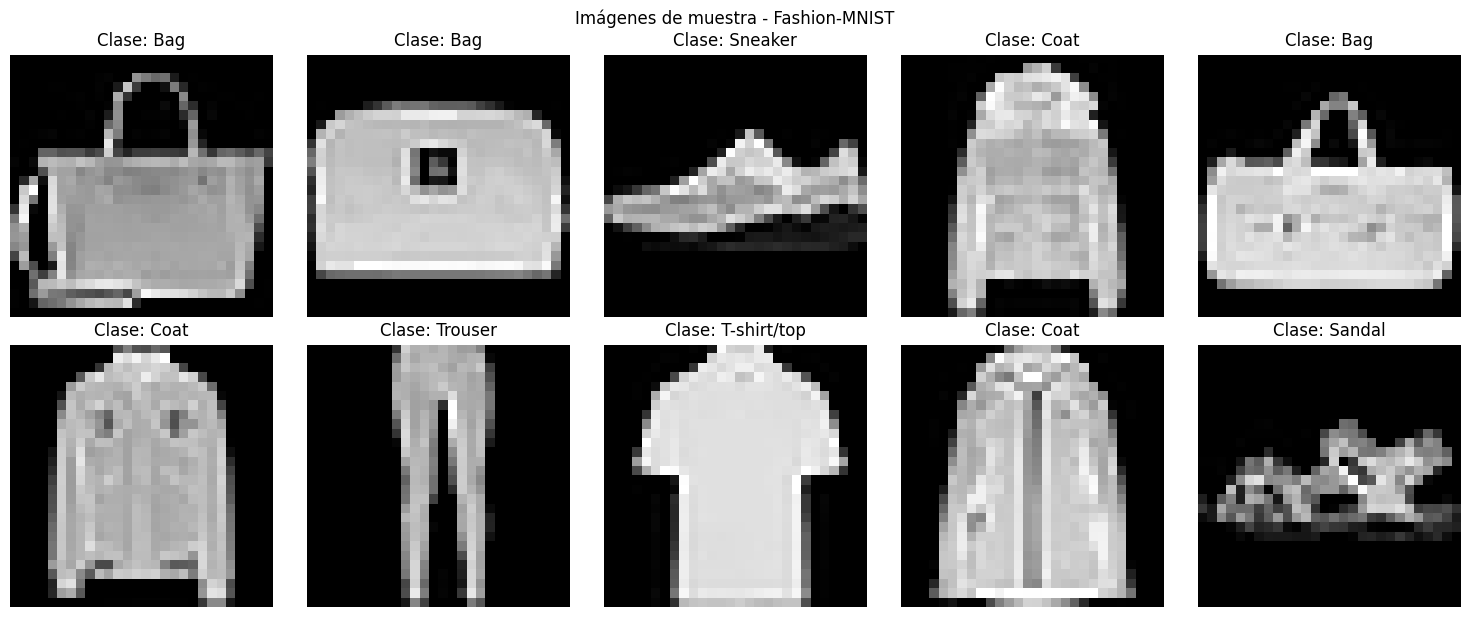

Aplicando PCA...
Aplicando NMF...
Aplicando t-SNE...
Aplicando clustering...
Generando visualizaciones...


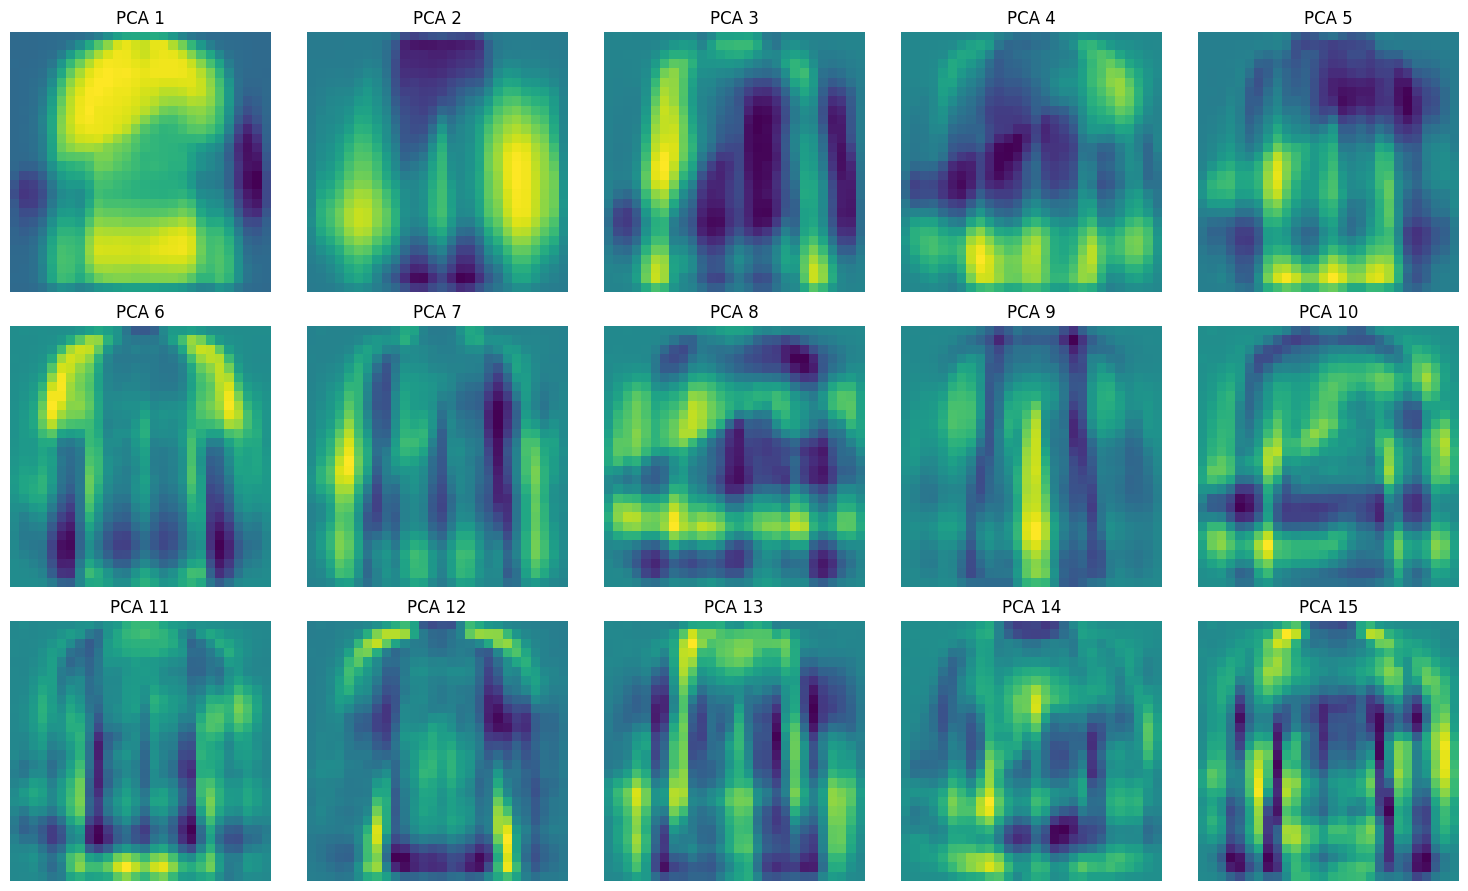

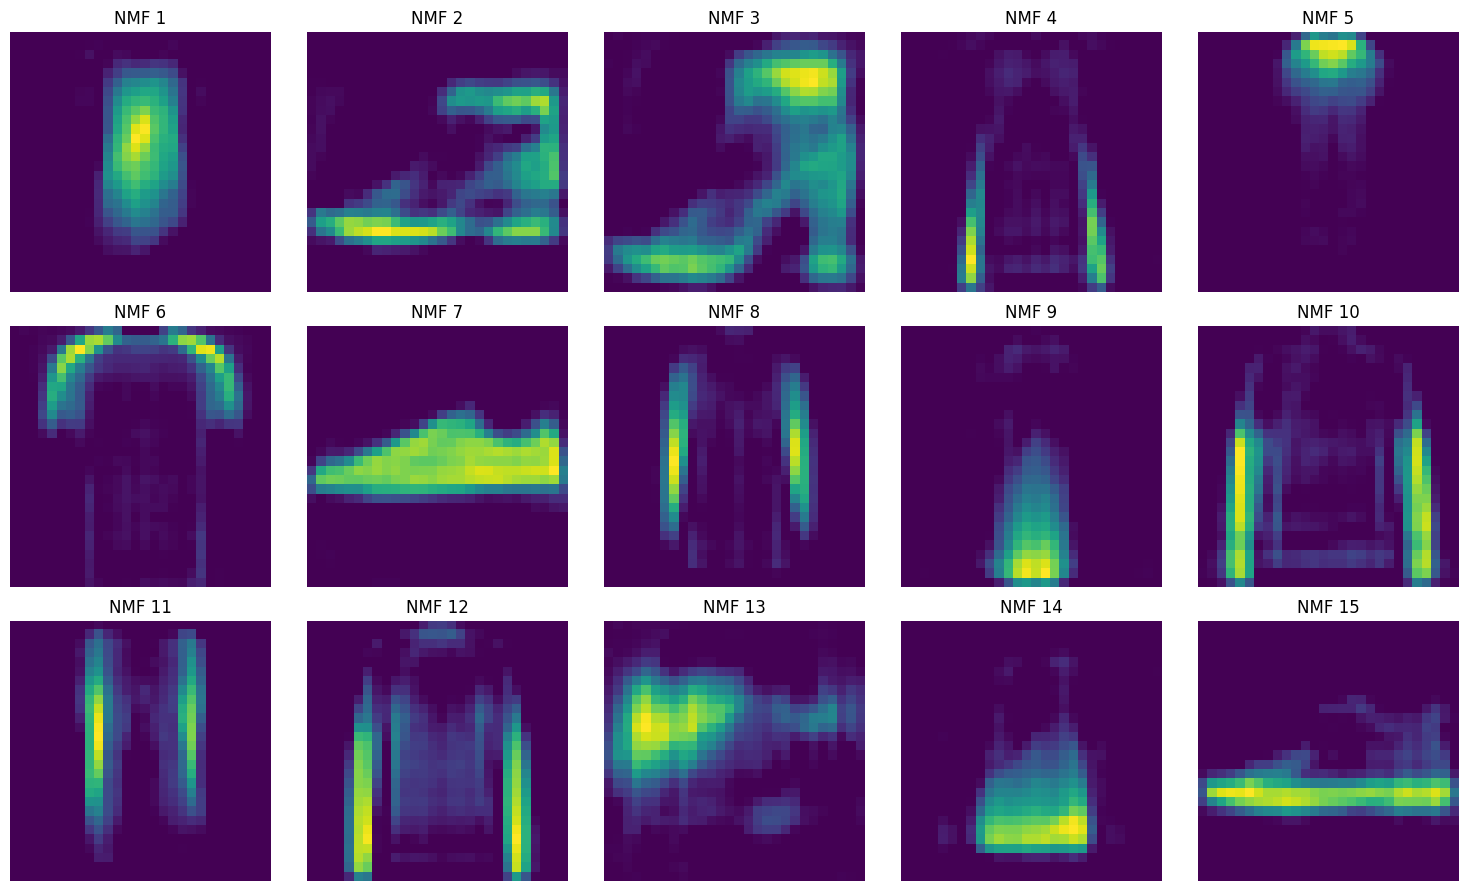

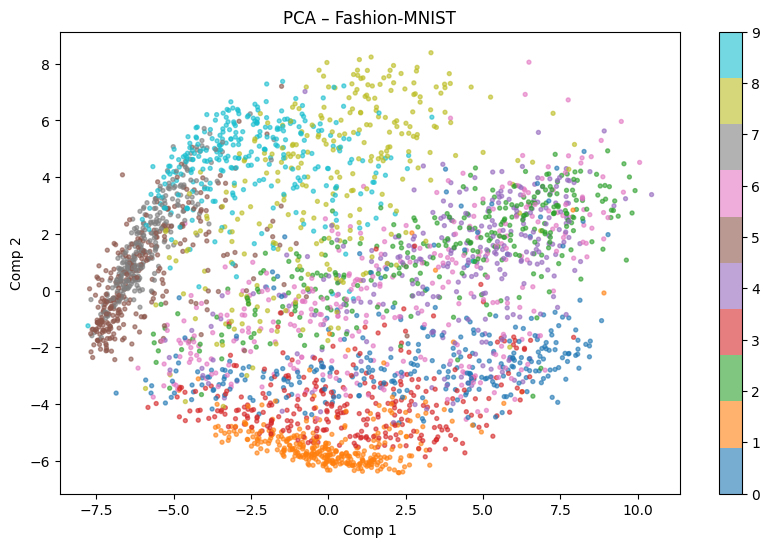

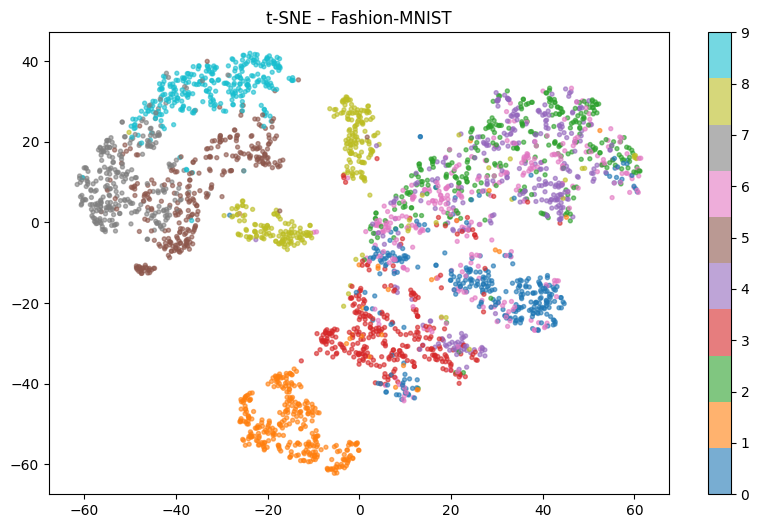


Evaluación de clustering:
PCA – Adjusted Rand Score: 0.371
NMF – Adjusted Rand Score: 0.248
PCA – Silhouette Score: 0.222
NMF – Silhouette Score: 0.279

========= Analizando CIFAR10 =========


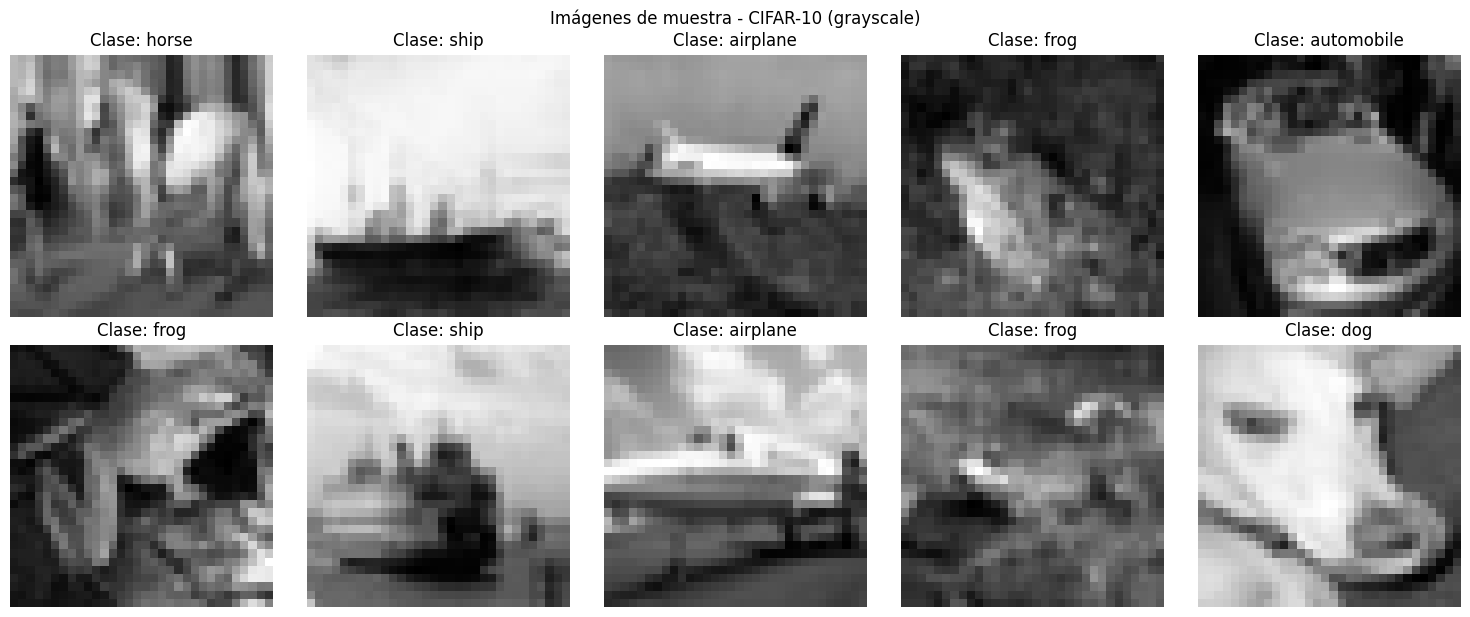

Aplicando PCA...
Aplicando NMF...


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Aplicando t-SNE...
Aplicando clustering...
Generando visualizaciones...


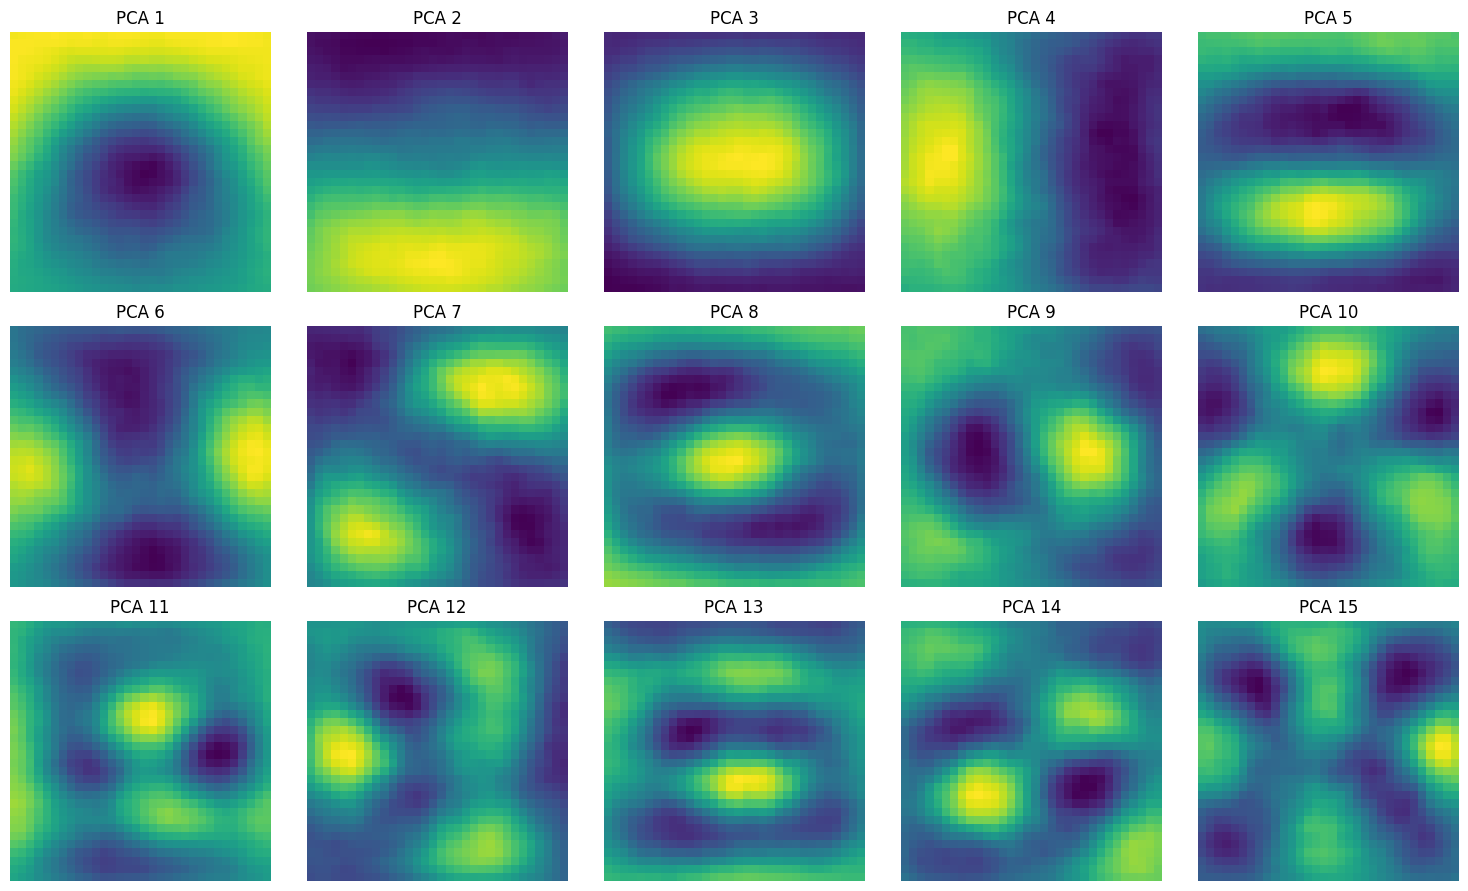

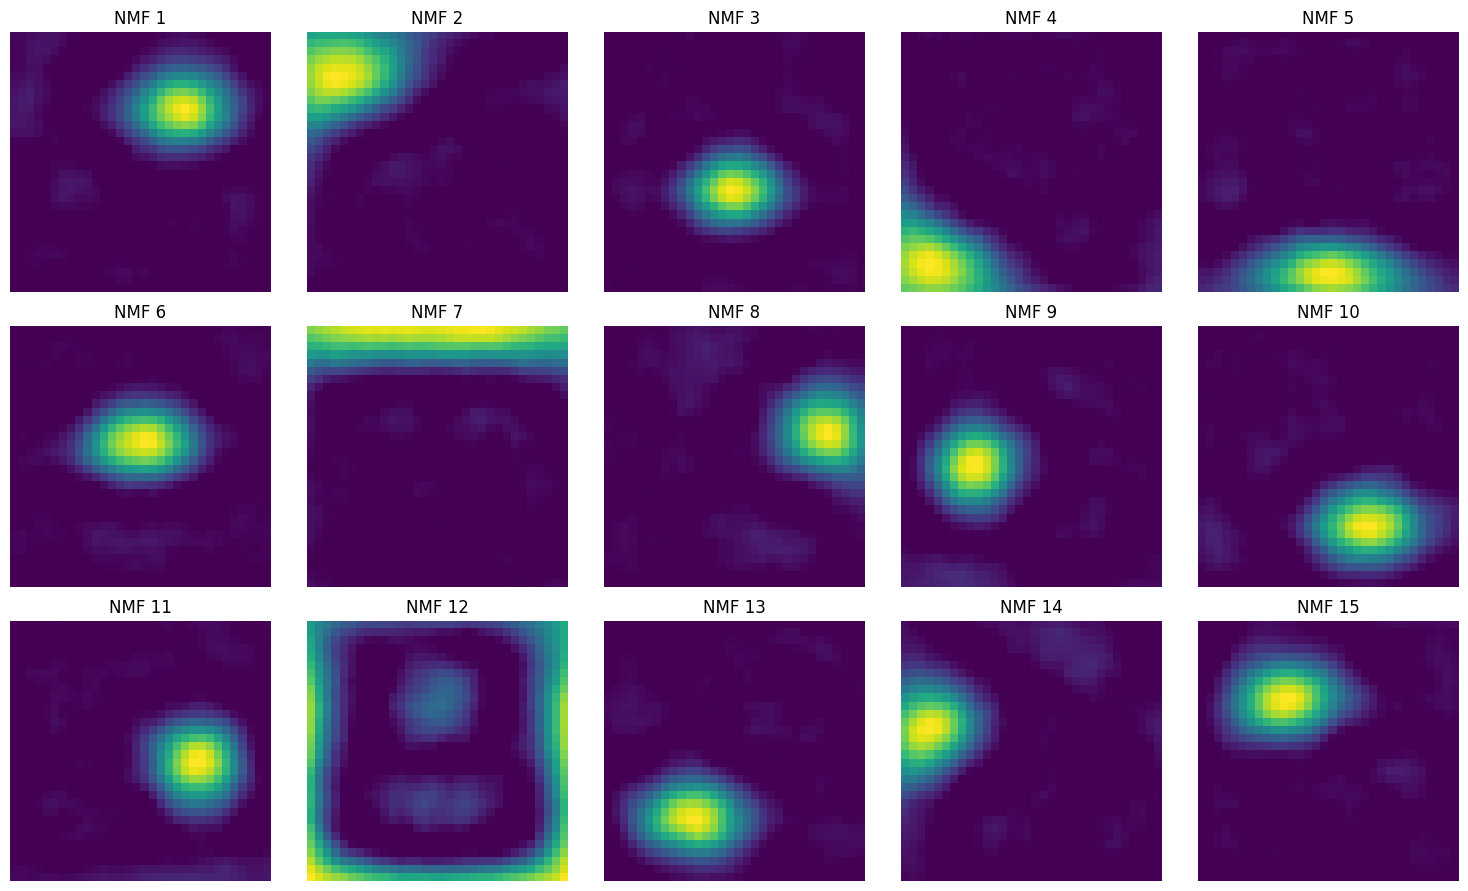

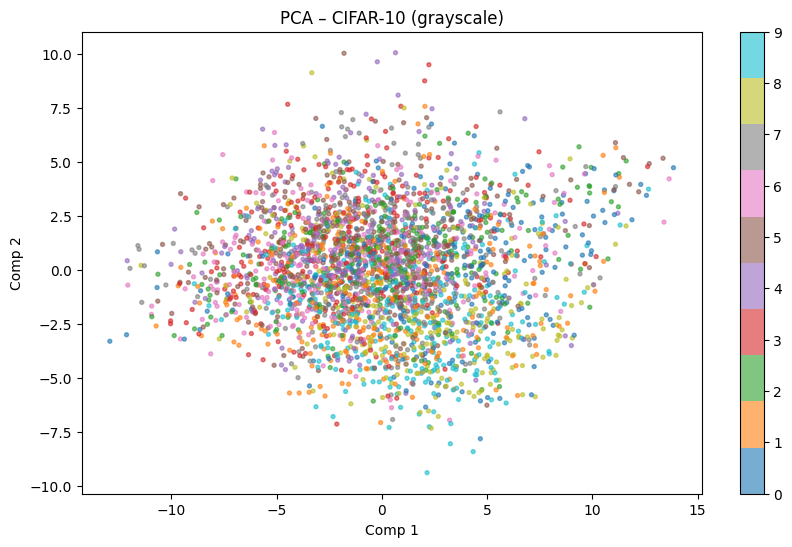

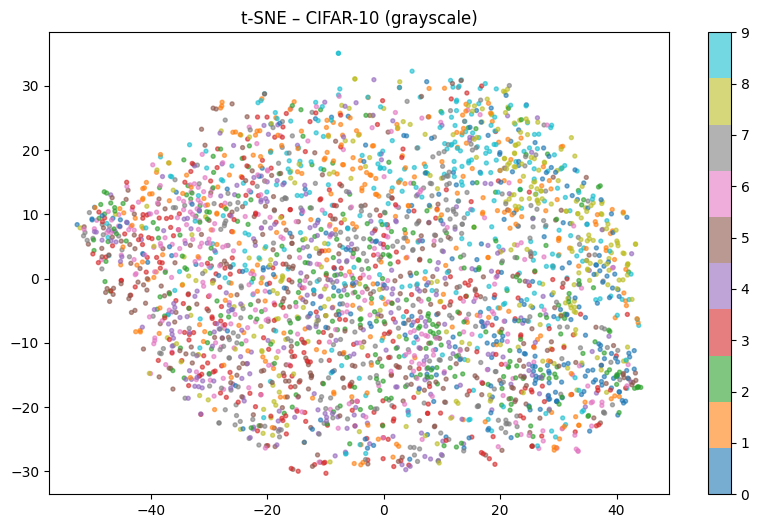


Evaluación de clustering:
PCA – Adjusted Rand Score: 0.028
NMF – Adjusted Rand Score: 0.020
PCA – Silhouette Score: 0.090
NMF – Silhouette Score: 0.094

2. REDES NEURONALES
Redes neuronales usando: cpu
Iniciando entrenamiento...
Época 1/5, Pérdida: 0.766
Época 2/5, Pérdida: 0.371
Época 3/5, Pérdida: 0.326
Época 4/5, Pérdida: 0.302
Época 5/5, Pérdida: 0.284

Resultados MNIST:
Precisión: 92.35%
Precisión (métrica): 0.9235
Exhaustividad: 0.9235


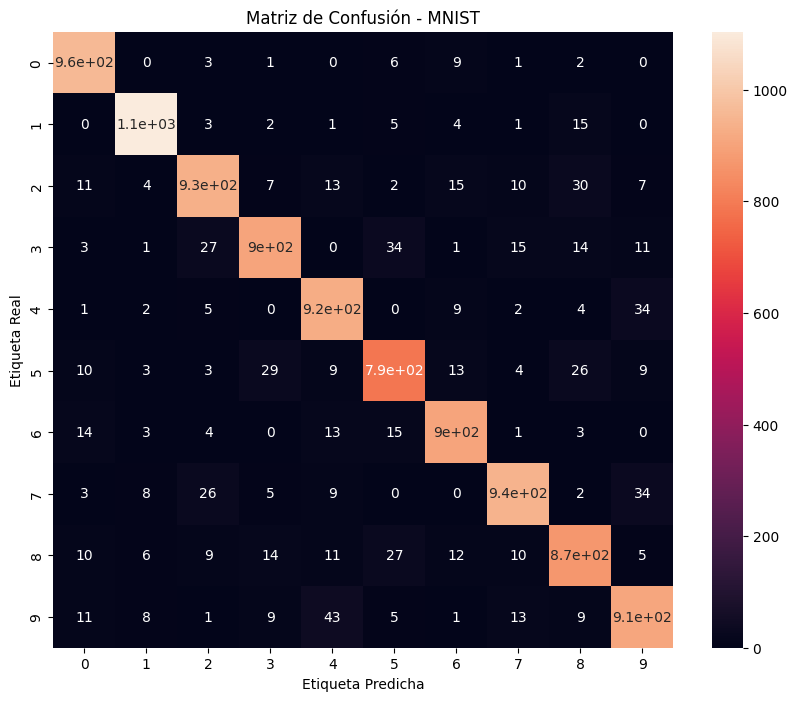

Iniciando entrenamiento...
Época 1/5, Pérdida: 1.864
Época 2/5, Pérdida: 1.102
Época 3/5, Pérdida: 0.833
Época 4/5, Pérdida: 0.708
Época 5/5, Pérdida: 0.642

Resultados Fashion-MNIST:
Precisión: 76.68%
Precisión (métrica): 0.7571
Exhaustividad: 0.7668


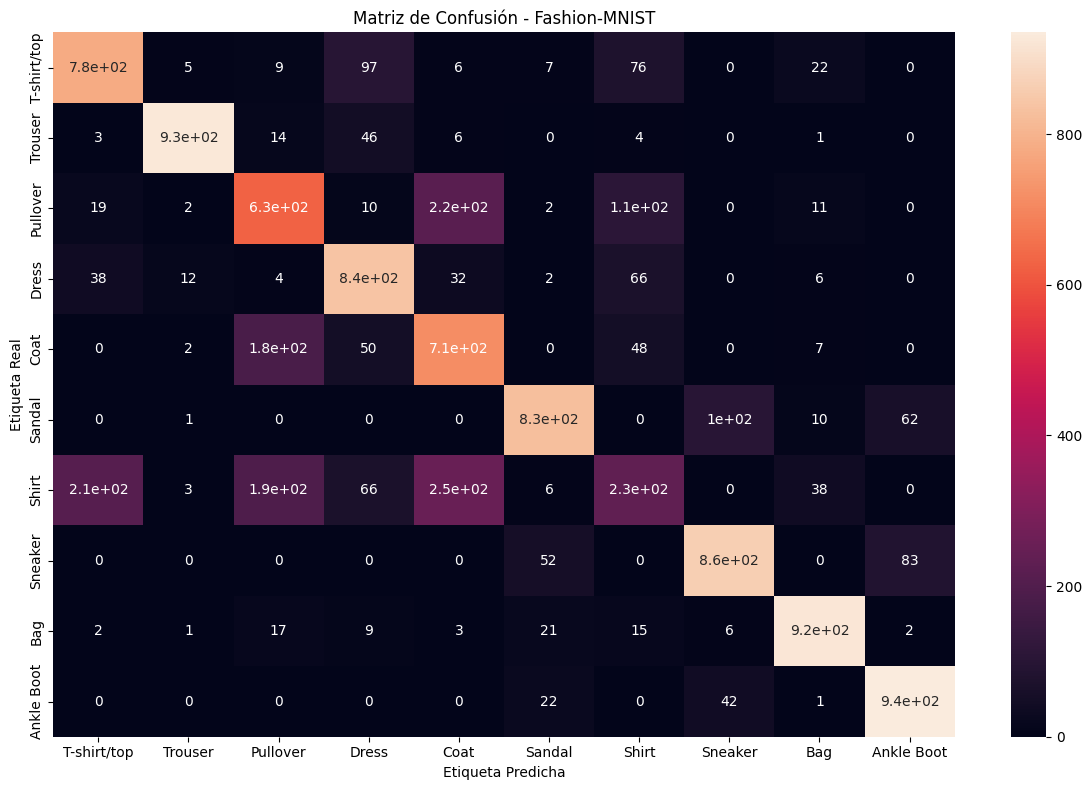


Métricas por clase:
T-shirt/top : Precisión=0.740, Recall=0.778
Trouser     : Precisión=0.973, Recall=0.926
Pullover    : Precisión=0.602, Recall=0.628
Dress       : Precisión=0.751, Recall=0.840
Coat        : Precisión=0.580, Recall=0.714
Sandal      : Precisión=0.881, Recall=0.826
Shirt       : Precisión=0.422, Recall=0.232
Sneaker     : Precisión=0.853, Recall=0.865
Bag         : Precisión=0.906, Recall=0.924
Ankle Boot  : Precisión=0.864, Recall=0.935
Arquitectura: Fully Connected
Iniciando entrenamiento...
Época 1/5, Pérdida: 1.877
Época 2/5, Pérdida: 1.655
Época 3/5, Pérdida: 1.570
Época 4/5, Pérdida: 1.513
Época 5/5, Pérdida: 1.465

Resultados CIFAR-10 (Fully Connected):
Precisión: 48.74%
Precisión (métrica): 0.4874
Exhaustividad: 0.4874


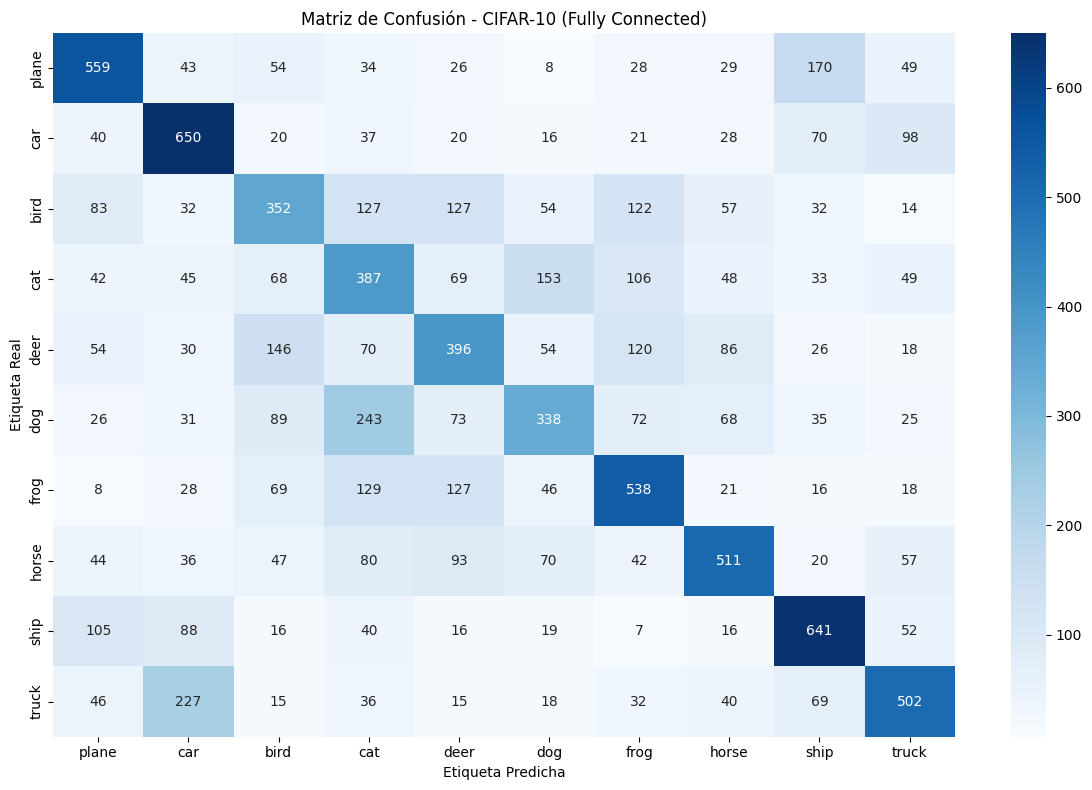

Arquitectura: LeNet
Iniciando entrenamiento...
Época 1/5, Pérdida: 2.276
Época 2/5, Pérdida: 2.065
Época 3/5, Pérdida: 1.834
Época 4/5, Pérdida: 1.667
Época 5/5, Pérdida: 1.574

Resultados CIFAR-10 (LeNet):
Precisión: 44.35%
Precisión (métrica): 0.4416
Exhaustividad: 0.4435


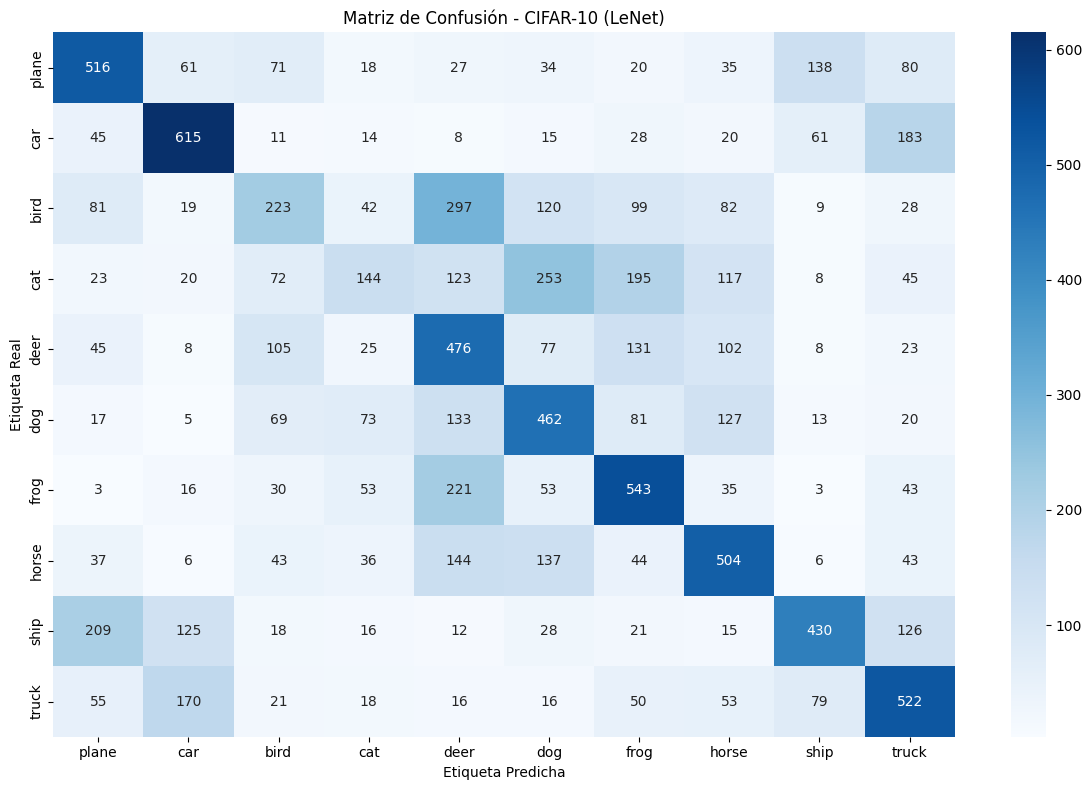


RESUMEN FINAL DE RESULTADOS

MNIST:
  Precisión: 92.35%
  Precisión (métrica): 0.9235
  Exhaustividad: 0.9235

FASHION:
  Precisión: 76.68%
  Precisión (métrica): 0.7571
  Exhaustividad: 0.7668

CIFAR10_FC:
  Precisión: 48.74%
  Precisión (métrica): 0.4874
  Exhaustividad: 0.4874

CIFAR10_LENET:
  Precisión: 44.35%
  Precisión (métrica): 0.4416
  Exhaustividad: 0.4435


In [ ]:
def main():

    print("\n1.PCA, NMF, Clustering")
    processor = ImageProcessor()
    processor.load_mnist()
    processor.load_fashion_mnist()
    processor.load_cifar10()

    processor.analyze_dataset('mnist', 3000)
    processor.analyze_dataset('fashion', 3000)
    processor.analyze_dataset('cifar10', 3000)

    print("\n2. REDES NEURONALES")
    nn_trainer = NeuralNetworks()

    nn_trainer.train_mnist_network()
    nn_trainer.train_fashion_network()
    nn_trainer.train_cifar_network(use_lenet=False)
    nn_trainer.train_cifar_network(use_lenet=True)

#Resumen final de resultados
    for dataset, result in nn_trainer.results.items():
        print(f"\n{dataset.upper()}:")
        print(f"  Precisión: {result['accuracy']:.2f}%")
        print(f"  Precisión (métrica): {result['precision']:.4f}")
        print(f"  Exhaustividad: {result['recall']:.4f}")

    return processor, nn_trainer

if __name__ == "__main__":
    processor, nn_trainer = main()